# Dynamical decoupling errors
Dynamical decoupling (DD) sequences are used to protect the NV-center from the influence of nearby nuclei through periodic refocussing of the spin density by application of pi-pulses in the x-y-plane. However, in the following simulation it can be seen, that if the MW-frequency is detuned with respect to the Rabi-frequency, the DD does not work properly (i.e. the NV-center accumulates a phase over the course of the sequence as the pi-pulses are not perfect pi-pulses anymore). It has to be kept in mind, that MW-detunings also arise from the hyperfine interaction of the NV with nitrogen spins. Combination with limited MW-power output (i.e. slow Rabi-oscillations) might result in the break down of the DD effect.


In the following simulation four different cases are implemented: a pure Ramsey-experiment (without DD-protection), and the CPMG, XY4 and KDD protocolls. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as q
import tqdm

#author: Rouven

In [18]:
tau = np.linspace(0,100,50)             # Pulse spacings in mus
Delta = np.linspace(0, 0.39, 50)        # Relative detuning between MW- and Larmor-frequency, given in units of the Rabi-Frequency
rho0 = q.fock_dm(2,0)                   # Initialized NV density matrix
omega = 2 * np.pi * 0.16                # Rabi-Frequency in rads * MHz

# Spin operators
sz = q.sigmaz() * 0.5
sx = q.sigmax() * 0.5
sy = q.sigmay() * 0.5

# Perfect pi/2 pulses for initialization and readout (unaffected by detuning in simulation)
pi_2_g_e_x = q.qip.operations.gates.rotation(op=q.sigmax(), phi=np.pi/2.0, N=1, target=0) # pi/2 x-rot
pi_2_g_e_y = q.qip.operations.gates.rotation(op=q.sigmay(), phi=np.pi/2.0, N=1, target=0) # pi/2 y-rot

# Lists of pi-pulse angles of sequences (all 100 pulses long)
ramsey = np.array(()) * np.pi / 180
CPMG = np.array(([0,0,0,0] * 25)) * np.pi / 180
XY4 = np.array(([0, 90, 0, 90] * 25)) * np.pi / 180
KDD20 = np.array(([30, 0, 90, 0, 30, 120, 90, 180, 90, 120, 30, 0, 90, 0, 30, 120, 90, 180, 90, 120] * 5)) * np.pi / 180    # Knill-DD
pulses = [ramsey, CPMG, XY4, KDD20]

# Propagation funtion
def propagate(rho, tau, omega, H0, phis):       # rho: denisty matrix, tau: pulse spacing, omega: rabi-freq, H0: free precession Hamiltonian, phis: pulse-angles for dynamical decoupling sequence
    Uints = {}                                  # dict to store unitary matrices for reuse
    rho = pi_2_g_e_x * rho * pi_2_g_e_x.dag()   # pi_2_x for init
    U0_t_2 = (- H0 * 1j * tau/2).expm()         # unitary matrix for free precession under H0
    for phi in phis:                            # loop over all pulses of decoupling sequence
        rho = U0_t_2 * rho * U0_t_2.dag()       # propagate for tau/2 under H0
        if str(phi) in Uints:                   # if interaction unitary was already created, reuse it
            rho = Uints[str(phi)] * rho * Uints[str(phi)].dag()
        else:
            Hint = H0 + omega * (np.cos(phi) * sx + np.sin(phi) * sy)   # interaction Hamiltonian during pi pulses
            Uint = (- Hint * 1j * np.pi / omega).expm()                 # propagator for pi-pulse
            Uints[str(phi)] = Uint                                      # add unitary to library
            rho = Uint * rho * Uint.dag()                               
        rho = U0_t_2 * rho * U0_t_2.dag()       # propagate for tau/2 under H0
    if len(phis) == 0:                          # special case to propagate Ramsey-experiment (whithout any pi pulses) by tau
        rho = U0_t_2 * U0_t_2 * rho * U0_t_2.dag() * U0_t_2.dag()
    rho = pi_2_g_e_x * rho * pi_2_g_e_x.dag()   # pi_2_x for readout
    return rho


results = []
for pulse in pulses:
    res = np.ones((len(Delta), len(tau)))   # array for sz-measurement results
    n = 0
    for t in tqdm.tqdm_notebook(tau):       # for all pulse-spacings
        for m, d in enumerate(Delta):       # for all detunings
            H0 = d * omega * sz             # free precession Hamiltonian
            rho = propagate(rho = rho0, tau = t, omega = omega,  H0 = H0, phis = pulse)    # propagate 
            try:
                res[m][n] = q.expect(sz, rho)
            except Exception as e:
                res[m][n] = np.real(q.expect(sz, rho))
                print(q.expect(sz, rho))
        n += 1
    results.append(res)

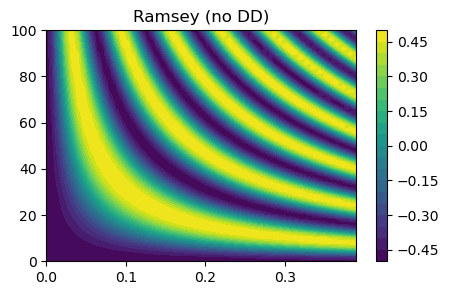

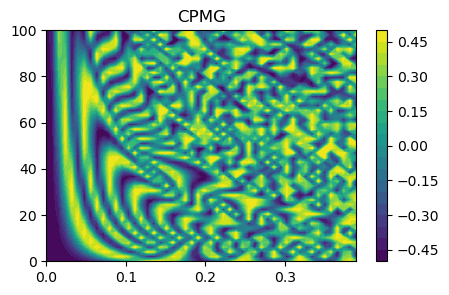

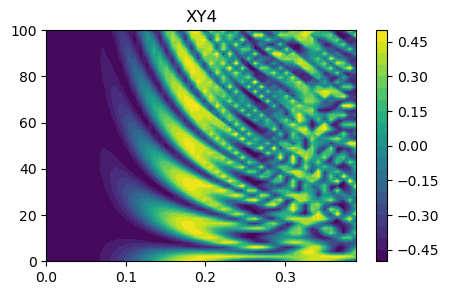

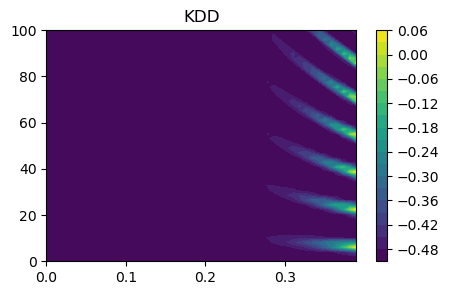

In [21]:
labels = ['Ramsey (no DD)', 'CPMG', 'XY4', 'KDD']
Y, X = np.meshgrid(tau, Delta)
for i,j in zip(results,labels):
    fig,ax = plt.subplots(figsize = (5,3))
    cs = ax.contourf(X, Y, i, cmap = 'viridis', levels = 20)
    cbar = fig.colorbar(cs)
    ax.set_title(j)
    plt.show()